In [171]:
%load_ext autoreload
%autoreload 2

import numpy as np
import mne
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from mne.preprocessing import ICA
from mne.decoding import CSP
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from dataset import EEGDataset
import filter as filter
from mlp import TorchDataset, MLP, NNTrainTest
from plot import plot_eeg, plot_scatter_trials



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read Dataset

In [144]:
file_path_1 = "../BCICIV_1_mat/BCICIV_calib_ds1a"
data = EEGDataset(file_path_1, start_window=0.5, end_window=3)

# Preprocessing

## Filters

In [145]:
laplacin_filtered = filter.large_laplacian_filter(data)
bandpass_filterd = filter.bandpass_filter(laplacin_filtered,  l_freq=8, h_freq=40)

Setting up band-pass filter from 8 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 11800 out of 11800 | elapsed:    2.0s finished


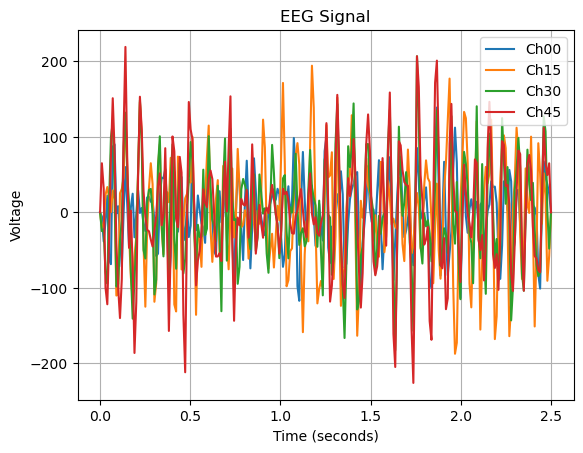

In [172]:
plot_eeg(data, 0, 'EEG Signal')
plt.savefig('../assets/preprocess_raw.png')

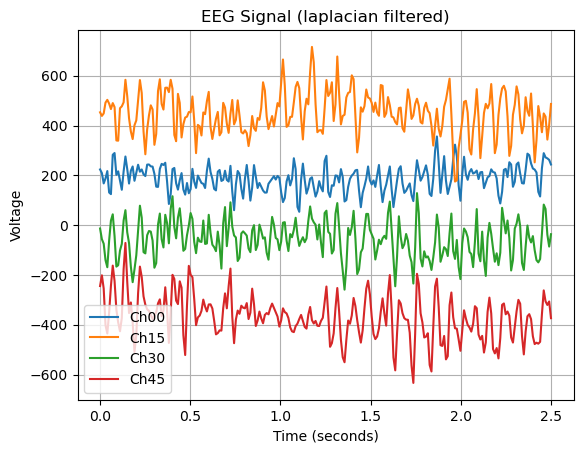

In [79]:
plot_eeg(laplacin_filtered, 0, 'EEG Signal (laplacian filtered)')
plt.savefig('../assets/preprocess_laplacian.png')

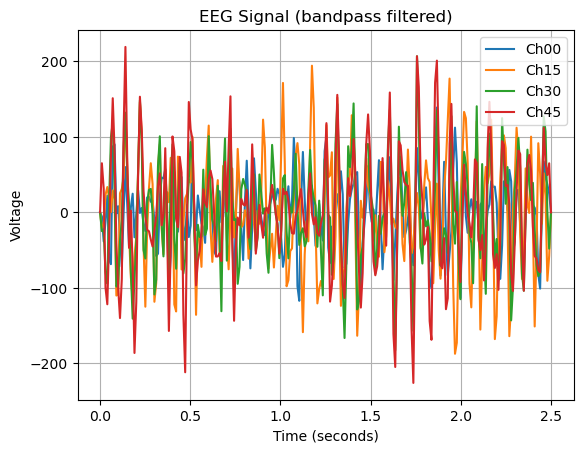

In [80]:
plot_eeg(bandpass_filterd, 0, 'EEG Signal (bandpass filtered)')
plt.savefig('../assets/preprocess_bandpass.png')

In [156]:
data = bandpass_filterd

## Train Test Split

In [157]:
X = data.trials
y = data.targets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=40,
    stratify=y
)

## PCA

In [53]:
pca = PCA(n_components=40)
X_train_pca = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_pca = pca.transform(X_test.reshape(X_test.shape[0], -1))

In [54]:
X_train_csp = X_train_pca
X_test_csp = X_test_pca

In [128]:
a = np.array([[[1, 2], [3, 4]], [[6, 7], [8, 9]]])
a

array([[[1, 2],
        [3, 4]],

       [[6, 7],
        [8, 9]]])

In [129]:
a.reshape(2, -1)

array([[1, 2, 3, 4],
       [6, 7, 8, 9]])

## ICA

In [5]:
import numpy as np
from sklearn.decomposition import FastICA

n_samples = 200
n_features = 250
n_channels = 59
n_components = 59



ica = FastICA(n_components=n_components, random_state=42)
S = ica.fit_transform(X_train.reshape(X_train.shape[0], n_features * n_channels))
A = ica.mixing_

X_train_csp = S
X_test_csp = ica.transform(X_test.reshape(X_test.shape[0], -1))


In [183]:
import numpy as np
from sklearn.decomposition import FastICA

# Generate sample data
n_samples = 200
n_features = 250
n_channels = 59
n_components = 7



ica = FastICA(n_components=n_components, random_state=42)
S = ica.fit_transform(X_train[:, 10, :], n_features * n_channels)
A = ica.mixing_

X_train_csp = S
X_test_csp = ica.transform(X_test[:, 10, :])


In [163]:
X_train_csp.shape

(150, 7)

## CSP

In [170]:
csp = CSP(n_components=59, reg=None, log=None, norm_trace=False)
X_train_csp = csp.fit_transform(X_train, y_train)
X_test_csp = csp.transform(X_test)

Computing rank from data with rank=None
    Using tolerance 1.5e+03 (2.2e-16 eps * 59 dim * 1.1e+17  max singular value)
    Estimated rank (data): 59
    data: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


In [56]:
X_train_csp = X_train
X_test_csp = X_test

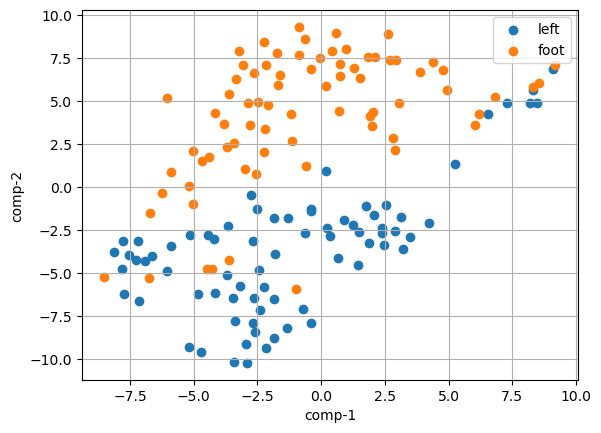

In [159]:
plot_scatter_trials(X_train_csp, y_train, data.class_labels)

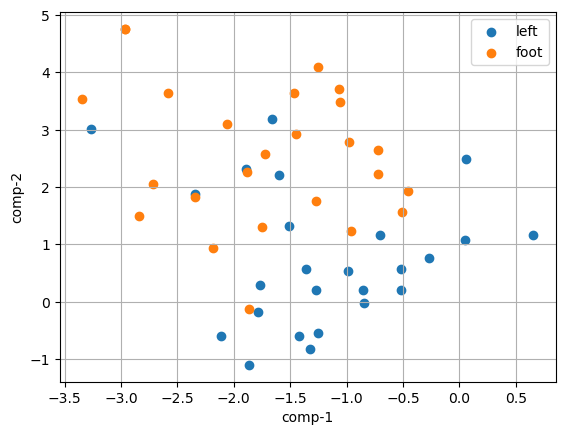

In [160]:
plot_scatter_trials(X_test_csp, y_test, data.class_labels)

## Logistic Regression

In [161]:

model = LogisticRegression(max_iter=300)
model.fit(X_train_csp, y_train)
y_pred = model.predict(X_test_csp)
accuracy_score(y_test, y_pred)

0.92

## SVM

In [162]:
model = SVC(kernel='rbf', C=1.0)
model.fit(X_train_csp, y_train)
y_pred = model.predict(X_test_csp)
accuracy_score(y_test, y_pred)

0.92

## KNN

In [166]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train_csp, y_train)
y_pred = model.predict(X_test_csp)
accuracy_score(y_test, y_pred)

0.54

## MLP

In [164]:
X_train_csp = X_train.reshape(X_train.shape[0], -1)
X_test_csp = X_test.reshape(X_test.shape[0], -1)

In [168]:
num_classes = 2
num_epochs = 2
batch_size = 64
learning_rate = 0.001
input_shape = (-1, 59)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mlp_clf = MLP(input_shape, num_classes).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_clf.parameters(), lr=learning_rate)

NNTrainTest(mlp_clf, device).train(num_epochs, TorchDataset(X_train_csp, y_train), batch_size, learning_rate)

NNTrainTest(mlp_clf, device).test(TorchDataset(X_test_csp, y_test), batch_size)

# Clustering

/home/mehdi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


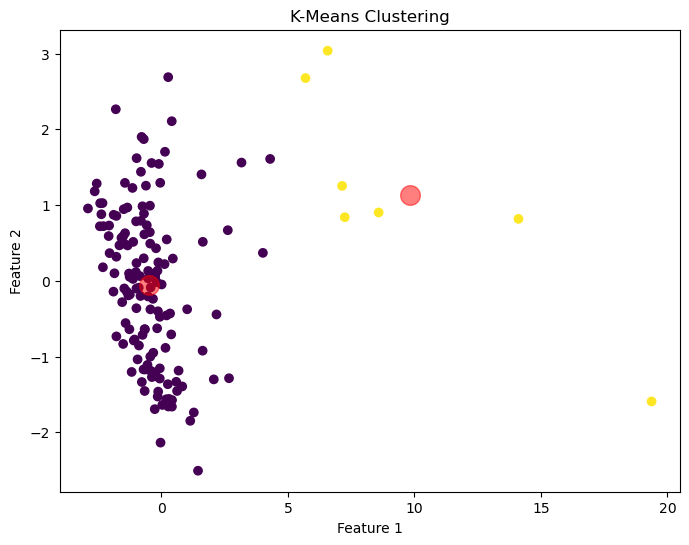

In [256]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_csp)

labels = kmeans.labels_

# Get cluster centroids


pca = PCA(n_components=2)
X = pca.fit_transform(X_train_csp)
centroids = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.5)
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [258]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_score
print("silhouette: ", silhouette_score(X_train_csp, labels))
print("homegenity: ", homogeneity_score(y_train, labels))


silhouette:  0.7109215066652862
homegenity:  0.0007229831808636991


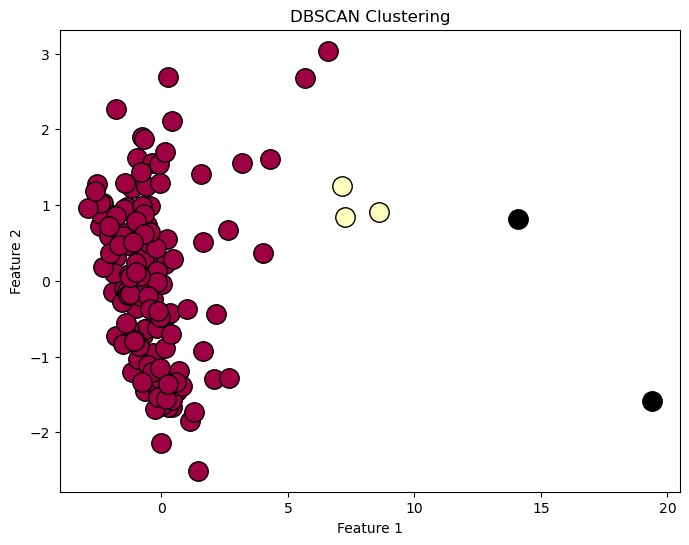

In [253]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=3, min_samples=2)
labels = dbscan.fit_predict(X_train_csp)

pca = PCA(n_components=2)
X = pca.fit_transform(X_train_csp)

unique_labels = set(labels)

# Plot the results
plt.figure(figsize=(8, 6))
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for label, color in zip(unique_labels, colors):
    if label == -1:
        # Black used for noise points
        color = [0, 0, 0, 1]

    class_member_mask = (labels == label)
    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(color),
             markeredgecolor='k', markersize=14)

plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [255]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_score
print("silhouette: ", silhouette_score(X_train_csp, labels))
print("homegenity: ", homogeneity_score(y_train, labels))


silhouette:  0.6250485623876524
homegenity:  0.0016672489850587998
